In [2]:
!pip install neurokit2
!pip install xgboost

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=df3b0f5fcd30d741781d4f35d70d9f661f758ef6e7680e609fd1473125f37161
  Stored in directory: C:\Users\Lea\AppData\Local\pip\Cache\wheels\76\03\bb\589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import neurokit2 as nk
from pprint import pprint

# ML
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

# Custom
import sys,os
sys.path.append( '.' )
sys.path.append( '..' )
import Components.data_fetching as data_fetching
import Components.feature_extraction as feature_extraction

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(data_fetching)
importlib.reload(feature_extraction)

<module 'Components.feature_extraction' from '../Components/feature_extraction.py'>

# Data Fetching

In [7]:
y = np.ravel(data_fetching.get_train_data(y_only=True))


In [4]:
X = feature_extraction.get_features(types=['timeseries', 'heartbeats', 'peaks'], verbose=True, precomputed='train')
X_test = feature_extraction.get_features(types=['timeseries', 'heartbeats', 'peaks'], verbose=True, precomputed='test')

scaling

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test_sc = scaler.transform(X_test)

# Feature selection

In [8]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False,max_iter=5000).fit(X, y)
model1 = SelectFromModel(lsvc, prefit=True)
X_new = model1.transform(X)
X_new.shape

(5117, 132)

In [18]:
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False,max_iter=5000).fit(X, y)
model2 = SelectFromModel(lsvc, prefit=True)
X_new2 = model2.transform(X)
X_new2.shape

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(5117, 293)

In [38]:
lsvc = LinearSVC(C=1, penalty="l1", dual=False,max_iter=5000).fit(X, y)
model3 = SelectFromModel(lsvc, prefit=True)
X_new3 = model3.transform(X)
X_new3.shape

(5117, 417)

# Outlier detection

with C=0.01

In [10]:
detector = IsolationForest(contamination=170/5117,random_state=42)
labels = pd.DataFrame(detector.fit_predict(X_new))
labels.where(labels ==  -1).count()

0    170
dtype: int64

In [14]:
detector = IsolationForest()
labels = pd.DataFrame(detector.fit_predict(X_new))
labels.where(labels ==  -1).count()

0    197
dtype: int64

with C=0.1

In [24]:
detector = IsolationForest()
labels2 = pd.DataFrame(detector.fit_predict(X_new2))
labels2.where(labels2 ==  -1).count()

0    173
dtype: int64

with C=1

In [46]:
detector = IsolationForest()
labels3 = pd.DataFrame(detector.fit_predict(X_new3))
labels3.where(labels3 ==  -1).count()

C:\Users\Lea\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    512
dtype: int64

without any feature selection before

In [47]:
detector = IsolationForest()
labels4 = pd.DataFrame(detector.fit_predict(X))
labels4.where(labels4 ==  -1).count()

C:\Users\Lea\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    512
dtype: int64

remove found outliers

In [15]:
X1 = pd.DataFrame(X_new)[labels[0]==1]
X1_all = pd.DataFrame(X)[labels[0]==1]
y1 = pd.DataFrame(y)[labels[0]==1]

In [25]:
X2 = pd.DataFrame(X_new2)[labels2[0]==1]
X2_all = pd.DataFrame(X)[labels2[0]==1]
y2 = pd.DataFrame(y)[labels2[0]==1]

In [59]:
X3 = pd.DataFrame(X_new3)[labels3[0]==1]
X3_all = pd.DataFrame(X)[labels3[0]==1]
y3 = pd.DataFrame(y)[labels3[0]==1]

# Training

In [26]:


clf = xgb.XGBClassifier()
cv_score = cross_val_score(clf, X2, np.ravel(y2), cv=10, scoring='f1_micro',n_jobs=16)
print(cv_score)
print(np.mean(cv_score))

# 1st attempt
# [0.62304688 0.71875    0.76953125 0.74414062 0.73046875 0.72265625
# 0.7109375  0.7260274  0.72994129 0.66144814]
# 0.7136948079745596

# 2nd attempt
# [0.73242188 0.74023438 0.83007812 0.7578125  0.75976562 0.74804688
# 0.76171875 0.74168297 0.73972603 0.75342466]
# 0.7564911784491194

# 3rd attempt (luke's features)
# [0.72070312 0.76171875 0.82421875 0.76757812 0.78515625 0.75585938
# 0.76171875 0.76125245 0.7592955  0.77299413]
# 0.7670495199363991

# 4th attempt (luke's + lea's features)
# [0.80859375 0.79492188 0.83984375 0.81640625 0.80273438 0.80664062
# 0.81054688 0.78669276 0.7964775  0.82387476]
# 0.8086732509784735

# 147 outliers, 132 features
#[0.81287726 0.80482897 0.83098592 0.81287726 0.80080483 0.80885312
# 0.80684105 0.80885312 0.80885312 0.82293763]
# 0.811871227364185

# 147 outliers, all features
# [0.81086519 0.80885312 0.82092555 0.81891348 0.82092555 0.81891348
# 0.80885312 0.80482897 0.81891348 0.81488934]
# 0.8146881287726357

# 175 outliers, 282 features
#[0.82626263 0.80606061 0.85222672 0.82995951 0.82186235 0.81174089
# 0.81578947 0.7854251  0.8097166  0.82793522]
# 0.8186979102768575

#175 outliers, all features
#[0.82222222 0.81414141 0.84008097 0.81578947 0.82591093 0.80769231
# 0.80566802 0.78744939 0.80769231 0.82591093]
#0.8152557968347441


# 186 outliers, 407 features
#[0.82388664 0.80324544 0.84381339 0.81947262 0.82758621 0.79918864
# 0.82758621 0.78904665 0.80730223 0.82150101]
#0.8162629033185242

# 186 outliers, all features
#[0.83805668 0.80730223 0.83772819 0.80933063 0.82352941 0.81135903
# 0.81744422 0.78498986 0.80527383 0.8296146 ]
# 0.8164628688275533

[0.8040404  0.7959596  0.84848485 0.81818182 0.82388664 0.81174089
 0.81781377 0.78744939 0.80566802 0.81376518]
0.8126990553306342


# Predict

In [27]:
clf = xgb.XGBClassifier()
clf.fit(X2,np.ravel(y2))


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

(array([0.64966286, 0.07944884, 0.25007329, 0.02081501]),
 array([0, 1, 2, 3, 4]),
 <BarContainer object of 4 artists>)

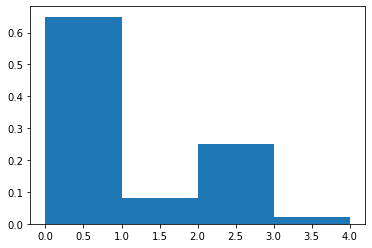

In [29]:
X_test_transf = pd.DataFrame(model2.transform(X_test_sc))
y_pred = clf.predict(X_test_transf)
plt.hist(y_pred,bins=[0,1, 2, 3, 4],density=True)

In [30]:
y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
y_pred_pd.to_csv('../../Predictions/XGB_173outliers_293features_test.csv', index_label='id')